- [previous file - EDA](2022-03-31_train-test_EDA.ipynb)
- [previous file - sklearn experiments](2022-04-12_experiments-sklearn.ipynb)
- [next file - ensembles](2022-04-15_ensemble.ipynb)

## imports

In [42]:
from warnings import filterwarnings
import os
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

sns.set()
filterwarnings("ignore")

## preprocessing

### reading data

In [43]:
# path_to_data = "data"
path_to_data = "https://github.com/XelorR/sf_project_6/raw/master/data"

train_raw = pd.read_parquet(f"{path_to_data}/2022-04-08_train_pre-model.parquet")
test_raw = pd.read_parquet(f"{path_to_data}/2022-04-08_test_pre-model.parquet")

train_raw.shape, test_raw.shape

((115367, 30), (34686, 28))

### functions

In [44]:
def train_or_load(clf, X, y, filepath: str = "model.joblib", complevel: int = 9):
    """
    Fits and serialize model as .pkl, .pickle or .joblib file.
    Loads serialized model if filepath exists.

    clf - model to fit
    X - dateset
    y - lables
    filepath - where to save
    complevel - compression level (0-9) for joblib, ignored for pickle
    """
    if filepath.endswith(".joblib"):
        if os.path.exists(filepath):
            with open(filepath, "rb") as f:
                clf = joblib.load(f)
        else:
            clf.fit(X, y)
            with open(filepath, "wb") as f:
                joblib.dump(clf, f, compress=complevel)
        return clf
    elif filepath.endswith(".pkl") or filepath.endswith(".pickle"):
        if os.path.exists(filepath):
            with open(filepath, "rb") as f:
                clf = pickle.load(f)
        else:
            clf.fit(X, y)
            with open(filepath, "wb") as f:
                pickle.dump(clf, f)
        return clf


def submit(hold_out: pd.DataFrame, model, name="submission"):
    preds = model.predict(hold_out)
    submission = pd.read_csv(f"{path_to_data}/sample_submission.csv")
    submission["price"] = preds
    submission.to_csv(f"{name}.csv", index=False)


def submit_log(hold_out: pd.DataFrame, model, name="submission"):
    preds = model.predict(hold_out)
    submission = pd.read_csv(f"{path_to_data}/sample_submission.csv")
    submission["price"] = np.exp(preds)
    submission.to_csv(f"{name}.csv", index=False)

### encoding

In [45]:
train_raw["train/test"] = "train"
test_raw["train/test"] = "test"

data = train_raw.append(test_raw)
data["ptc"].fillna("Оригинал", inplace=True)

data[data.select_dtypes("object").columns.tolist()] = data[
    data.select_dtypes("object").columns.tolist()
].astype(str)

for col in set(data.select_dtypes(exclude=("object")).columns) - {"price"}:
    data[col] = (
        RobustScaler().fit_transform(data[col].values.reshape(-1, 1)).reshape(-1, 1)
    )

for col in ["model_name"]:
    data[col] = LabelEncoder().fit_transform(data[col].astype("str"))

data = pd.get_dummies(
    data,
    columns=[
        "vehicle_transmission",
        "vendor",
        "brand",
        "fuel_type",
        "body_type",
        "color",
        "ptc",
        "drive",
        "wheel",
        "age_cat",
    ],
)

train = data.loc[data["train/test"] == "train"]

train_jane = train.loc[train["sample"] == "jane"]
train_sokolov = train.loc[train["sample"] == "sokolov"]
train_jane["price"] = train_jane["price"] * 0.86
train = train_jane.append(train_sokolov)

train.drop(columns=["sample", "description", "train/test"], inplace=True)
test = data.loc[data["train/test"] == "test"].drop(
    columns=["sample", "description", "train/test", "price"]
)

### preparing to train models

In [46]:
if os.path.exists("models"):
    pass
else:
    os.mkdir("models")

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop(columns="price"), train["price"], random_state=1337, shuffle=True
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((86525, 112), (86525,), (28842, 112), (28842,))

## Experiment

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.backend import clear_session

print("We're using TF", tf.__version__)
print("We are using Keras", tf.keras.__version__)

We're using TF 2.8.0
We are using Keras 2.8.0


In [49]:
clear_session()

model = Sequential()

model.add(Dense(768, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(768, activation="relu"))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(768, activation="relu"))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1))

model.compile(loss="mean_absolute_percentage_error", optimizer="adam", metrics=["mean_absolute_percentage_error"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 768)               86784     
                                                                 
 dense_1 (Dense)             (None, 2048)              1574912   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 768)               1573632   
                                                                 
 dense_3 (Dense)             (None, 2048)              1574912   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 768)               1

In [50]:
%%time
history = model.fit(
    X_train, y_train, epochs=1000, batch_size=1024, validation_data=(X_valid, y_valid)
)

Epoch 1/1000
85/85 [==============================] - 3s 23ms/step - loss: 72.6022 - mean_absolute_percentage_error: 72.6022 - val_loss: 56.7361 - val_mean_absolute_percentage_error: 56.7361
Epoch 2/1000
85/85 [==============================] - 2s 18ms/step - loss: 36.3844 - mean_absolute_percentage_error: 36.3844 - val_loss: 30.6071 - val_mean_absolute_percentage_error: 30.6071
Epoch 3/1000
85/85 [==============================] - 2s 19ms/step - loss: 25.9601 - mean_absolute_percentage_error: 25.9601 - val_loss: 22.2246 - val_mean_absolute_percentage_error: 22.2246
Epoch 4/1000
85/85 [==============================] - 2s 18ms/step - loss: 22.5839 - mean_absolute_percentage_error: 22.5839 - val_loss: 21.5351 - val_mean_absolute_percentage_error: 21.5351
Epoch 5/1000
85/85 [==============================] - 1s 18ms/step - loss: 21.5557 - mean_absolute_percentage_error: 21.5557 - val_loss: 19.2329 - val_mean_absolute_percentage_error: 19.2329
Epoch 6/1000
85/85 [=========================

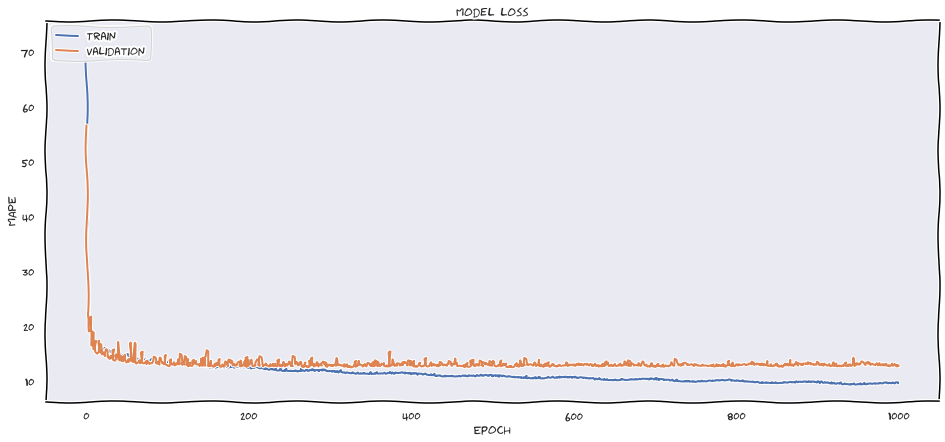

In [51]:
with plt.xkcd():
    plt.subplots(figsize=(16, 7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [52]:
submit(test, model, "keras_v4")

In [53]:
mean_absolute_percentage_error(y_valid, model.predict(X_valid)) * 100

13.058503755544612

In [54]:
model.save("models/keras_v4")

INFO:tensorflow:Assets written to: models/keras_v4/assets


In [55]:
!7z a models/keras_v4.7z models/keras_v4


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Open archive: models/keras_v4.7z
--
Path = models/keras_v4.7z
Type = 7z
Physical Size = 70451548
Headers Size = 301
Method = LZMA2:24
Solid = +
Blocks = 1

Scanning the drive:
  0M Scan           3 folders, 4 files, 95758916 bytes (92 MiB)

Updating archive: models/keras_v4.7z

Items to compress: 7

  0%      0% 2 U models/keras_v4/variables/variables.data-00000-of-00001                                                                  2% 2 U models/keras_v4/variables/variables.data-00000-of-00001                                                                